In [ ]:
!pip install -U -q evaluate transformers datasets>=2.14.5 accelerate>=0.27 2>/dev/null

# -q --> quiet bakalan surpress outputnya
# -evaluate --> Buat Evaluasi
# -transformers -> Biasanya buat load pre-trained model
# -datasets -> Untuk mempermudah akses datasets
# -mlflow -> Open-source platform buat nanti sharing + reproduce modelnya

In [ ]:
import warnings
warnings.filterwarnings("ignore")

import gc # Garbage Collection
import numpy as np
import pandas as pd
import itertools # Iterations + looping
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, roc_auc_score, confusion_matrix, classification_report, f1_score

from imblearn.over_sampling import RandomOverSampler
import accelerate
import evaluate
from datasets import Dataset, Image, ClassLabel
from transformers import TrainingArguments, Trainer, ViTImageProcessor, ViTForImageClassification, DefaultDataCollator

import torch
from torch.utils.data import DataLoader
from torchvision.transforms import CenterCrop, Compose, Normalize, RandomRotation, RandomResizedCrop, RandomHorizontalFlip, RandomAdjustSharpness, Resize, ToTensor


In [ ]:
from PIL import ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
# Bikin Sistemnya bisa load gambar walaupun gambarnya corrupt/rusak

In [ ]:
from google.colab import files
files.upload()

Saving kaggle(2).json to kaggle(2).json


{'kaggle(2).json': b'{"username":"kevinpetersen","key":"388c4fd8735f5f0227c9b0b41fe70276"}'}

In [ ]:
!mkdir -p ~/.kaggle
!mv kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

mv: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory


In [ ]:
!kaggle datasets download manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [00:53<00:00, 34.5MB/s]
100% 1.68G/1.68G [00:53<00:00, 33.7MB/s]


In [ ]:
!unzip deepfake-and-real-images.zip

Streaming output truncated to the last 5000 lines.
  inflating: Dataset/Validation/Real/real_5499.jpg  
  inflating: Dataset/Validation/Real/real_55.jpg  
  inflating: Dataset/Validation/Real/real_550.jpg  
  inflating: Dataset/Validation/Real/real_5500.jpg  
  inflating: Dataset/Validation/Real/real_5501.jpg  
  inflating: Dataset/Validation/Real/real_5502.jpg  
  inflating: Dataset/Validation/Real/real_5503.jpg  
  inflating: Dataset/Validation/Real/real_5504.jpg  
  inflating: Dataset/Validation/Real/real_5505.jpg  
  inflating: Dataset/Validation/Real/real_5506.jpg  
  inflating: Dataset/Validation/Real/real_5507.jpg  
  inflating: Dataset/Validation/Real/real_5508.jpg  
  inflating: Dataset/Validation/Real/real_5509.jpg  
  inflating: Dataset/Validation/Real/real_551.jpg  
  inflating: Dataset/Validation/Real/real_5510.jpg  
  inflating: Dataset/Validation/Real/real_5511.jpg  
  inflating: Dataset/Validation/Real/real_5512.jpg  
  inflating: Dataset/Validation/Real/real_5513.jpg  

In [ ]:
image_dict = {}

from pathlib import Path
from tqdm import tqdm
import os

file_names = []
labels = []

# Iterasi seluruh file image dalam directory yang spesifik
for file in sorted((Path('Dataset/').glob('*/*/*.*'))):
  label = str(file).split('/')[-2] # Extract Label
  labels.append(label)
  file_names.append(str(file))

print(len(file_names), len(labels))

df = pd.DataFrame.from_dict({"Image": file_names, "Label": labels})
print(df.shape)

190335 190335
(190335, 2)


Check Dataset

In [ ]:
df.head()

,Image,Label
0,Dataset/Test/Fake/fake_0.jpg,Fake
1,Dataset/Test/Fake/fake_1.jpg,Fake
2,Dataset/Test/Fake/fake_10.jpg,Fake
3,Dataset/Test/Fake/fake_100.jpg,Fake
4,Dataset/Test/Fake/fake_1000.jpg,Fake


In [ ]:
df['Label'].unique()

array(['Fake', 'Real'], dtype=object)

Preprocessing Data Imagenya

In [ ]:
y = df[['Label']] # y berisikan label yang mau kita predict

# Drop Kolom 'Label' buat misahin antara target variabelnya dengan fiturnya
df = df.drop(['Label'], axis=1)

ros = RandomOverSampler(random_state=83) # Random Seednya bebas

# df bakal nyimpan Fitur Data
# y_resampled = nyimpan target variabel yang udah di resample
df, y_resampled = ros.fit_resample(df, y)

del y # Delete Y agar memorynya lebih lega

df['Label'] = y_resampled

del y_resampled

gc.collect()

print(df.shape)

(190402, 2)


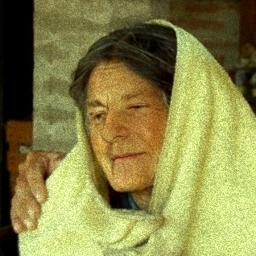

In [ ]:
dataset = Dataset.from_pandas(df).cast_column("Image", Image())
dataset[0]["Image"]

In [ ]:
labels_subset = labels[:5]
print(labels_subset)

['Fake', 'Fake', 'Fake', 'Fake', 'Fake']


In [ ]:
labels_list = list(set(labels))
label2id, id2label = dict(), dict()

for i, label in enumerate(labels_list):
  label2id[label] = i
  id2label[i] = label

print("Mapping of IDs to Labels:", id2label, '\n')
print("Mapping of Labels to IDs:", label2id)

Mapping of IDs to Labels: {0: 'Real', 1: 'Fake'} 

Mapping of Labels to IDs: {'Real': 0, 'Fake': 1}


In [ ]:
ClassLabels = ClassLabel(num_classes=len(labels_list), names=labels_list)

def map_label2id(example):
  example['Label'] = ClassLabels.str2int(example['Label'])
  return example

dataset = dataset.map(map_label2id, batched=True)
dataset = dataset.cast_column("Label", ClassLabels)
dataset = dataset.train_test_split(test_size=0.4, shuffle=True, stratify_by_column="Label")
train_data = dataset['train']
test_data = dataset['test']

Map:   0%|          | 0/190402 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/190402 [00:00<?, ? examples/s]

In [ ]:
model_str = "google/vit-base-patch16-224-in21k"
processor = ViTImageProcessor.from_pretrained(model_str)
image_mean, image_std = processor.image_mean, processor.image_std
size = processor.size["height"]
print("Size: ", size)

normalize = Normalize(mean=image_mean, std=image_std)

_train_transforms = Compose([
    Resize((size, size)),
    RandomRotation(90),
    RandomAdjustSharpness(2),
    ToTensor(),
    normalize
])

_val_transforms = Compose([
    Resize((size, size)),
    ToTensor(),
    normalize
])

def train_transforms(examples):
    examples['pixel_values'] = [_train_transforms(image.convert("RGB")) for image in examples['Image']]
    return examples

def val_transforms(examples):
    examples['pixel_values'] = [_val_transforms(image.convert("RGB")) for image in examples['Image']]
    return examples

preprocessor_config.json:   0%|          | 0.00/160 [00:00<?, ?B/s]

Size:  224


In [ ]:
train_data.set_transform(train_transforms)
test_data.set_transform(val_transforms)

In [ ]:
def collate_fn(examples):
    pixel_values = torch.stack([example["pixel_values"] for example in examples])
    labels = torch.tensor([example['Label'] for example in examples])
    return {"pixel_values": pixel_values, "labels": labels}

Load, Train + Evaluate Model

In [ ]:
model = ViTForImageClassification.from_pretrained(model_str, num_labels=len(labels_list))
model.config.id2label = id2label
model.config.label2id = label2id

print(model.num_parameters(only_trainable=True) / 1e6)

config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224-in21k and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


85.800194


In [ ]:
accuracy = evaluate.load("accuracy")

def compute_metrics(eval_pred):
  predictions = eval_pred.predictions
  label_ids = eval_pred.label_ids
  predicted_labels = predictions.argmax(axis=1)
  acc_score = accuracy.compute(predictions=predicted_labels, references=label_ids)['accuracy']
  return {
      "accuracy" : acc_score
  }

In [ ]:
metric_name = "accuracy"
model_name = "DeepFake Vs Real Image Detection"
num_train_epochs = 1

args = TrainingArguments(
    output_dir = model_name,
    logging_dir = "./logs",
    evaluation_strategy="epoch",
    learning_rate = 1e-6,
    per_device_train_batch_size = 64,
    per_device_eval_batch_size = 64,
    num_train_epochs = num_train_epochs,
    weight_decay = 0.02,
    warmup_steps = 50,
    remove_unused_columns = False,
    save_strategy = "epoch",
    load_best_model_at_end = True,
    save_total_limit=1,
    report_to="none"
)

In [ ]:
trainer = Trainer(
    model, #Pre-trained Model yang udah difine-tuned
    args, # HyperParameternya
    train_dataset=train_data,
    eval_dataset=test_data,
    data_collator=collate_fn,
    compute_metrics=compute_metrics,
    tokenizer=processor,
)

In [ ]:
# Evaluate Model sebelum proses Training
trainer.evaluate()

{'eval_loss': 0.6923068165779114,
 'eval_model_preparation_time': 0.0148,
 'eval_accuracy': 0.5172332296057037,
 'eval_runtime': 1075.0509,
 'eval_samples_per_second': 70.844,
 'eval_steps_per_second': 1.108}

In [ ]:
trainer.train()

Epoch,Training Loss,Validation Loss


Epoch,Training Loss,Validation Loss,Model Preparation Time,Accuracy
1,0.373400,0.496087,0.014800,0.848387


TrainOutput(global_step=1786, training_loss=0.4748604615351388, metrics={'train_runtime': 5249.7658, 'train_samples_per_second': 21.761, 'train_steps_per_second': 0.34, 'total_flos': 8.852762385560605e+18, 'train_loss': 0.4748604615351388, 'epoch': 1.0})

In [ ]:
# Evaluate Model setelah Training
trainer.evaluate()

{'eval_loss': 0.496086984872818,
 'eval_model_preparation_time': 0.0148,
 'eval_accuracy': 0.8483869697089061,
 'eval_runtime': 1087.6643,
 'eval_samples_per_second': 70.023,
 'eval_steps_per_second': 1.095,
 'epoch': 1.0}

In [ ]:
outputs = trainer.predict(test_data)
print(outputs.metrics)

{'test_loss': 0.496086984872818, 'test_model_preparation_time': 0.0148, 'test_accuracy': 0.8483869697089061, 'test_runtime': 1084.3865, 'test_samples_per_second': 70.234, 'test_steps_per_second': 1.098}


Accuracy: 0.8484
F1 Score: 0.8479


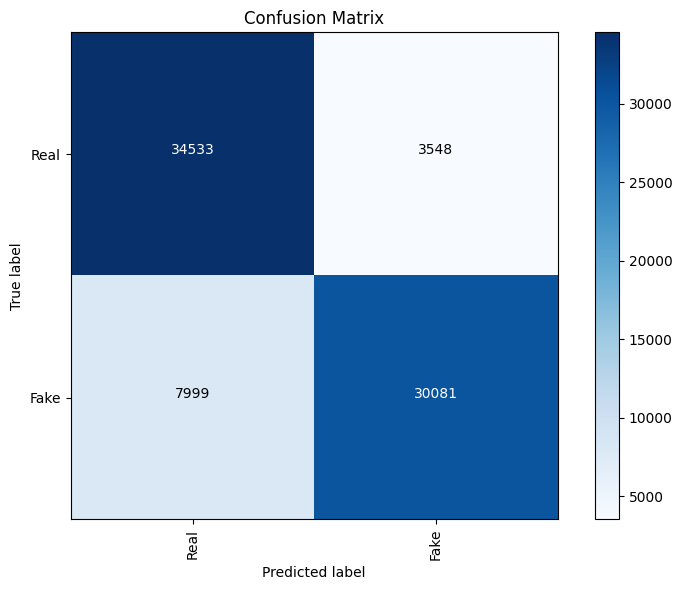


Classification report:

              precision    recall  f1-score   support

        Real     0.8119    0.9068    0.8568     38081
        Fake     0.8945    0.7899    0.8390     38080

    accuracy                         0.8484     76161
   macro avg     0.8532    0.8484    0.8479     76161
weighted avg     0.8532    0.8484    0.8479     76161



In [ ]:
y_true = outputs.label_ids
y_pred = outputs.predictions.argmax(axis=1)

def plot_confusion_matrix(cm, classes, title='Confusion Matrix', cmap=plt.cm.Blues, figsize=(10, 8)):
    """
    This function plots a confusion matrix.

    Parameters:
        cm (array-like): Confusion matrix as returned by sklearn.metrics.confusion_matrix.
        classes (list): List of class names, e.g., ['Class 0', 'Class 1'].
        title (str): Title for the plot.
        cmap (matplotlib colormap): Colormap for the plot.
    """
    # Create a figure with a specified size
    plt.figure(figsize=figsize)

    # Display the confusion matrix as an image with a colormap
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    # Define tick marks and labels for the classes on the axes
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=90)
    plt.yticks(tick_marks, classes)

    fmt = '.0f'
    # Add text annotations to the plot indicating the values in the cells
    thresh = cm.max() / 2.0
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    # Label the axes
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

    # Ensure the plot layout is tight
    plt.tight_layout()
    # Display the plot
    plt.show()

# Calculate accuracy and F1 score
accuracy = accuracy_score(y_true, y_pred)
f1 = f1_score(y_true, y_pred, average='macro')

# Display accuracy and F1 score
print(f"Accuracy: {accuracy:.4f}")
print(f"F1 Score: {f1:.4f}")

# Get the confusion matrix if there are a small number of labels
if len(labels_list) <= 150:
    # Compute the confusion matrix
    cm = confusion_matrix(y_true, y_pred)

    # Plot the confusion matrix using the defined function
    plot_confusion_matrix(cm, labels_list, figsize=(8, 6))

# Finally, display classification report
print()
print("Classification report:")
print()
print(classification_report(y_true, y_pred, target_names=labels_list, digits=4))

In [ ]:
trainer.save_model()

Device set to use cuda:0


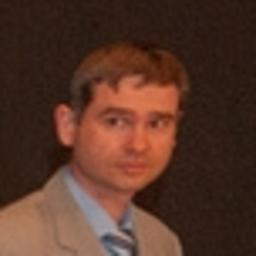

In [ ]:
from transformers import pipeline
pipe = pipeline('image-classification', model=model_name, device=0)

image = test_data[1]["Image"]
image

In [ ]:
# Buat Test Hasil Scorenya Fake berapa, Real Berapa
pipe(image)

[{'label': 'Real', 'score': 0.5550092458724976},
 {'label': 'Fake', 'score': 0.44934210181236267}]

In [ ]:
id2label[test_data[1]["Label"]]

'Real'

Saving Model ke Google Drive

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# Define the path in Google Drive where the model should be saved
save_path = "/content/drive/My Drive/deepfake_vs_real_image_detection_cv_project"

# Save the model to Google Drive
trainer.save_model(save_path)

# Optional: Save the processor as well
processor.save_pretrained(save_path)

print(f"Model saved to {save_path}")

Model saved to /content/drive/My Drive/deepfake_vs_real_image_detection_cv_project


Simpan Model ke HugginFace

In [ ]:
# from huggingface_hub import notebook_login
# notebook_login()

In [ ]:
# # Import the HfApi class from the huggingface_hub library.
# from huggingface_hub import HfApi

# # Create an instance of the HfApi class.
# api = HfApi()

# # Define the repository ID by combining the username "dima806" with the model name.
# repo_id = f"dima806/{model_name}"

# try:
#   # Attempt to create a new repository on the Hugging Face Model Hub using the specified repo_id.
#   api.create_repo(repo_id)

#   # If the repository creation is successful, print a message indicating that the repository was created.
#   print(f"Repo {repo_id} created")
# except:
#   # If an exception is raised, print a message indicating that the repository already exists.
#   print(f"Repo {repo_id} already exists")

In [ ]:
# # Uploading a folder to the Hugging Face Model Hub
# api.upload_folder(
#   folder_path=model_name,  # The path to the folder to be uploaded
#   path_in_repo=".",  # The path where the folder will be stored in the repository
#   repo_id=repo_id,  # The ID of the repository where the folder will be uploaded
#   repo_type="model",  # The type of the repository (in this case, a model repository)
#   revision="main" # Revision name
#   )